### EIGENSTRAT

Goal: To examine patterns of population structure in duplicated loci.

### Bring:
1. *.haplotypes.tsv file (produced by [Stacks](http://creskolab.uoregon.edu/stacks/))
    * used for dominant coding of each allele

2. genotype file in *.ped format
    * normal codominant genotypes of biallelic SNPs, used to compare 
    

### Take away:
* PCAs of genetic data:
    - full data coded as codominant genotypes (normal bi-allelic SNPs)
    - full data coded as dominant alleles
    - paralogs coded as dominant alleles

### Programs used:
* [EIGENSOFT](http://www.hsph.harvard.edu/alkes-price/software/) (specifically SMARTPCA)
 - Patterson N, Price AL, Reich D (2006) Population Structure and Eigenanalysis. PLoS Genet 2(12): e190. doi: 10.1371/journal.pgen.0020190
    
### Steps
1. a
2. b
3. c

#### Python imports

In [4]:
import collections
import numpy as np
import pandas as pd
import random
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

#### Plot formatting

In [5]:
sns.set(font_scale=2)
sns.set_style("white")
%matplotlib inline

#### Dominance coding
Haplotypes is a class to store the haplotypes assigned to a group of indidividuals at a particular catalog ID.  Each catalog ID is split into one 'locus' per observed haplotyped.  These loci are named as "catID_haplotype"

Genotypes of these dominant loci are scored as: 
    - 1 = allele is present
    - 0 = allele is absent
    - 9 = no call

In [6]:
class Haplotypes(object):
    def __init__(self, catID, ind_names, haplotypes, missing_codes = ["", "-", "No Call", 'Invalid', 'consensus']):
        self.catID = catID
        self.missing_codes = missing_codes
        self.haplotype_of_ind = collections.OrderedDict(zip(ind_names, haplotypes))
        self.set_alleles()
        self.split_catID_haplotypes()
        
    def set_alleles(self):    
        seen = set()
        for ind, haplo in self.haplotype_of_ind.items():
            if haplo in self.missing_codes:
                haplo = "-"
            else:
                haplo_set = frozenset(haplo.split("/"))
                for allele in haplo_set:
                    if allele not in self.missing_codes:
                        seen.add(allele)
        self.alleles = seen
        
    def split_catID_haplotypes(self):
        self.dom_coding_of_allele = dict()
        for allele in self.alleles:
            dom_coding = list()
            for xx in self.haplotype_of_ind.values():
                if xx is '-':
                    dom_coding.append(9)
                elif allele in xx.split('/'):
                    dom_coding.append(1)
                else:
                    dom_coding.append(0)
            self.dom_coding_of_allele['{}_{}'.format(self.catID, allele)] = dom_coding      

Trying out the Haplotypes class

In [7]:
INDNAMES = ['CMHAMM10_0002','CMHAMM10_0005','CMHAMM10_0008','CMHAMM10_0011','CMHAMM10_0012',
            'CMHAMM10_0014','CMHAMM10_0015','CMHAMM10_0016', 'CMHAMM10_0017','CMHAMM10_0018','CMHAMM10_0022',
            'CMHAMM10_0024']
HAPLOS = ['GG/TA','GG/TA','GG/TT','GG/TA','GG/TA','GG/TA','GG/TA','GG/TA','GG/TA','GG/TA','GG/TA','-']

AA = Haplotypes(catID='01', ind_names=INDNAMES, haplotypes=HAPLOS)

for ind, haplotypes in AA.haplotype_of_ind.items():
    print ind, haplotypes

for locus, genotypes in AA.dom_coding_of_allele.items():
    print locus, genotypes

CMHAMM10_0002 GG/TA
CMHAMM10_0005 GG/TA
CMHAMM10_0008 GG/TT
CMHAMM10_0011 GG/TA
CMHAMM10_0012 GG/TA
CMHAMM10_0014 GG/TA
CMHAMM10_0015 GG/TA
CMHAMM10_0016 GG/TA
CMHAMM10_0017 GG/TA
CMHAMM10_0018 GG/TA
CMHAMM10_0022 GG/TA
CMHAMM10_0024 -
01_TT [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 9]
01_GG [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9]
01_TA [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 9]


#### creating the input files for SMARTPCA - dominance coding
This function will encode genotypes as a set of dominant alleles.

- haplotypes_in = haplotypes.tsv (from Stacks)

- indiv_in = ped file of the individuals to retain

- catID_in = map or snplist file of the catIDs to retain

In [8]:
def write_dom_EIGENSTRAT_files(haplotypes_in, ind_in, catID_in, genotype_out, map_out):
    with open(ind_in) as ind_INFILE:
        ind_to_keep = [line.split()[1] for line in ind_INFILE]
        print('Inds to keep: {}'.format(len(ind_to_keep)))

    with open(catID_in) as catID_INFILE:
        try: # this works on map files - catId is found by spliting the snpID
            catId_to_keep = [line.split()[1].split('_')[0] for line in catID_INFILE]
        except IndexError: # this works on snplist files - each line is a catID to keep
            catId_to_keep = [line.strip() for line in catID_INFILE]
        print('catIds to keep: {}'.format(len(catId_to_keep)))

    with open(haplotypes_in) as INFILE:
        HEADER = next(INFILE)
        ind_names = HEADER.strip().split('\t')[2:]
        ind_keeps = [xx in ind_to_keep for xx in ind_names]
        kept_names = [xx for xx in ind_names if xx in ind_to_keep]
        with open(genotype_out, 'w') as geno_OUTFILE:
            with open(map_out, 'w') as map_OUTFILE:
                for line in INFILE:
                    catID = line.split('\t')[0]
                    if catID in catId_to_keep:
                        haplos = line.strip().split('\t')[2:]
                        kept_haplos = [xx for (cnt,xx) in enumerate(haplos) if ind_keeps[cnt]]
                        haps = Haplotypes(catID, kept_names, kept_haplos)
                        for allele, calls in haps.dom_coding_of_allele.items():
                            geno_OUTFILE.write(''.join([str(xx) for xx in calls]))
                            geno_OUTFILE.write('\n')
                            map_OUTFILE.write('1\t{}\t1\t1\n'.format(allele))

In [9]:
for locus, genotypes in AA.dom_coding_of_allele.items():
    print locus, genotypes

01_TT [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 9]
01_GG [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9]
01_TA [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 9]


Notice, these are based on **haplotypes** - rather than individual snps the codominant data is based on.


#### All mapped loci

In [10]:
write_dom_EIGENSTRAT_files(
    haplotypes_in = '/home/ipseg/Desktop/waples/chum_populations/data/batch_4/all.haplotypes.tsv',
    ind_in = '/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/on_map.ped',
    catID_in = '/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/on_map.map',
    genotype_out = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.tsv',
    map_out = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.map')

Inds to keep: 174
catIds to keep: 7259


In [11]:
linkage_map = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/linkage_map/LEPmap/with_paralogs/final/PS_chum_map_2015.txt', sep = '\t')
paralogs = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/linkage_map/chum_paralogs.txt', header = None)
paralogs.columns = ['old_CatID']
paralogs['contig'] = ['c' + str(xx) for xx in paralogs['old_CatID']]
paralogs['paralog'] = True
paralogs.head()

,old_CatID,contig,paralog
0,4,c4,True
1,5,c5,True
2,15,c15,True
3,26,c26,True
4,32,c32,True


In [12]:
catID_paralogs = set(pd.merge(linkage_map, paralogs)['stacks_CatID'])

In [13]:
with open('/home/ipseg/Desktop/waples/chum_populations/linkage_map/chum_paralogs.catIDs', 'w') as OUTFILE:
    for xx in catID_paralogs:
        OUTFILE.write('{}\n'.format(xx))

#### Just the mapped paralogs

In [14]:
write_dom_EIGENSTRAT_files(
    haplotypes_in = '/home/ipseg/Desktop/waples/chum_populations/data/batch_4/all.haplotypes.tsv',
    ind_in = '/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/on_map.ped',
    catID_in = '/home/ipseg/Desktop/waples/chum_populations/linkage_map/chum_paralogs.catIDs',
    genotype_out = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.tsv',
    map_out = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.map')

Inds to keep: 174
catIds to keep: 1214


#### I want to set up a way to better manage SmartPCA runs 
I want to be able to:
   * downsample
   * subset loci by paralog/non

### Steps to run SmartPCA
   * create infiles
       * genotype file
       * snp file
       * individual file
   * create parfile
   * call SmartPca
   
In order 


In [15]:
def subsample_map_file(infile, outfile, num_keep = 1000):
    with open(infile) as INFILE:
        num_loci = sum(1 for line in INFILE)
    lines_to_keep = random.sample(range(num_loci), num_keep)
    with open(outfile, 'w') as OUTFILE:
        with open(infile) as INFILE:
            idx = 0
            for line in INFILE:
                if idx in lines_to_keep:
                    OUTFILE.write(line)
                idx += 1

In [16]:
subsample_map_file(infile = '/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/on_map.map', 
                   outfile = '/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/on_map.map.subsample', num_keep = 1000)

In [17]:
def subsample_DOMINANT_map_file(infile, outfile, num_keep = 1000):
    with open(infile) as INFILE:
        loci = set([int(line.split()[1].split('_')[0]) for line in INFILE])
    loci_to_keep = random.sample(loci, num_keep)
    #print(loci_to_keep)
    with open(outfile, 'w') as OUTFILE:
        with open(infile) as INFILE:
            for line in INFILE:
                current_locus = int(line.split()[1].split('_')[0])
                if current_locus in loci_to_keep:
                    OUTFILE.write(line)

In [18]:
subsample_DOMINANT_map_file(infile = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.map', 
                   outfile = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.map.subsample', 
                            num_keep = 1000)

In [19]:
subsample_DOMINANT_map_file(infile = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.map', 
                   outfile = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.map.subsample', 
                            num_keep = 1000)

### subsample the genotype file.

In [20]:
cd /home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes

/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes


In [21]:
univseral_plink_commands = "--allow-extra-chr --allow-no-sex --write-snplist --autosome-num 50"

In [22]:
!plink --bfile complete --not-chr 0 --exclude paralog_SNPs.txt {univseral_plink_commands} \
    --thin-count 1000 --recode --make-bed --out mapped_non_paralogs_subset

PLINK v1.90b3q 64-bit (29 May 2015)        https://www.cog-genomics.org/plink2
(C) 2005-2015 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to mapped_non_paralogs_subset.log.
Options in effect:
  --allow-extra-chr
  --allow-no-sex
  --autosome-num 50
  --bfile complete
  --exclude paralog_SNPs.txt
  --make-bed
  --not-chr 0
  --out mapped_non_paralogs_subset
  --recode
  --thin-count 1000
  --write-snplist

32127 MB RAM detected; reserving 16063 MB for main workspace.
7259 variants loaded from .bim file.
174 samples (0 males, 0 females, 174 ambiguous) loaded from .fam.
Ambiguous sex IDs written to mapped_non_paralogs_subset.nosex .
--exclude: 6251 variants remaining.
--thin-count: 5251 variants removed (1000 remaining).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 174 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%

## Run Smartpca
Smartpca, within EIGENSOFT, is used for PCA analysis. Smartpca uses a parameter file to specify program options.

#### Notes

   * You may need to check your in input \*.map files, EIGENSOFT is excluding loci on chr=0.  If you want to retain unplaced loci, set chr (column 1) to 1.

   * smartpca also complains about the  6th column of the .ped file (phenotype) when the value is '-9' (ie. missing).  We can set this to 1 or 0 to remove this error, specifing cases or controls. see [FAQ](http://www.hsph.harvard.edu/alkes-price/eigensoft-frequently-asked-questions/)
   * Patterson (2006) notes that the normalization ('usenorm') should **not** be applied to dominance-coded data.


In [23]:
SMARTPCA_path = '/home/ipseg/Programs/EIGENSOFT/EIG6.0.1/bin/smartpca'

#### write parfile(s)

In [24]:
def function_to_write_parfiles(base_dir):
    ## TODO, this is a placeholder
    pass

In [25]:
on_map_dom_PARFILE_path = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.parfile'

with open(on_map_dom_PARFILE_path, 'w') as OUTFILE:
    OUTFILE.write('''\
genotypename:  /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.tsv
snpname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.map
indivname:       /home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/complete.ped

evecoutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.evec
evaloutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.eval
grmoutname:      /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.rel
snpweightoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.snpweights
deletesnpoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.snpremoved
outlieroutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.ind_outliers

fastmode:      NO
usenorm:       NO
missingmode:   NO
outliermode:   0 
numchrom:      50
numoutlieriter: 5 
numoutlierevec: 10 
lsqproject: NO \
    ''')

In [26]:
paralogs_dom_PARFILE_path = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.parfile'

with open(paralogs_dom_PARFILE_path, 'w') as OUTFILE:
    OUTFILE.write('''\
genotypename:  /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.tsv
snpname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.map
indivname:       /home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/complete.ped

evecoutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.evec
evaloutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.eval
grmoutname:      /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.rel
snpweightoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.snpweights
deletesnpoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.snpremoved
outlieroutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.ind_outliers

fastmode:      NO
usenorm:       NO
missingmode:   NO
outliermode:   0 
numchrom:      50
numoutlieriter: 5 
numoutlierevec: 10 
lsqproject: NO \
    ''')

In [27]:
on_map_codom_PARFILE_path = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.parfile'

with open(on_map_codom_PARFILE_path, 'w') as OUTFILE:
    OUTFILE.write('''\
genotypename:  /home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/on_map.ped
snpname:       /home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/on_map.map
indivname:       /home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/complete.ped

evecoutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.evec
evaloutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.eval
grmoutname:      /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.rel
snpweightoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.snpweights
deletesnpoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.snpremoved
outlieroutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.ind_outliers

fastmode:      NO
usenorm:       NO
missingmode:   NO
outliermode:   0 
numchrom:      50
numoutlieriter: 5 
numoutlierevec: 10 
lsqproject: NO \
    ''')

## subsamples

In [28]:
on_map_codom_subsample_PARFILE_path = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.parfile'

with open(on_map_codom_subsample_PARFILE_path, 'w') as OUTFILE:
    OUTFILE.write('''\
genotypename:  /home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/mapped_non_paralogs_subset.ped
snpname:       /home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/mapped_non_paralogs_subset.map
indivname:       /home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/complete.ped

evecoutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.evec
evaloutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.eval
grmoutname:      /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.rel
snpweightoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.snpweights
deletesnpoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.snpremoved
outlieroutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.ind_outliers

fastmode:      NO
usenorm:       NO
missingmode:   NO
outliermode:   0 
numchrom:      50
numoutlieriter: 5 
numoutlierevec: 10 
lsqproject: NO \
    ''')

#### call SMARTPCA

In [29]:
!{SMARTPCA_path} -p {on_map_dom_PARFILE_path} > \
 /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.logfile

In [30]:
!{SMARTPCA_path} -p {paralogs_dom_PARFILE_path}> \
 /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.logfile

In [31]:
!{SMARTPCA_path} -p {on_map_codom_PARFILE_path}> \
 /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.logfile

#### subsampling

In [32]:
##!{SMARTPCA_path} -p {on_map_dom_subsample_PARFILE_path}> \
## /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.subsample.logfile

In [33]:
!{SMARTPCA_path} -p {on_map_codom_subsample_PARFILE_path}> \
 /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.logfile

### Plot EIGENSOFT results

#### Manually color populations 

In [34]:
pop_colors = ['purply pink', 'golden', 'leaf green', 'blood', 'vomit', 'primary blue', 
              'bright sky blue', 'dark cyan', 'grey', 'red']

#### load SMARTPCA results

In [35]:
eigenvec_on_map_dom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.evec',
    sep = ' ', skipinitialspace = True)
eigenvec_on_map_dom.columns = ['ind', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'junk']
eigenvec_on_map_dom['POP'] = [xx.split(':')[0] for xx in eigenvec_on_map_dom['ind']]
eigenvec_on_map_dom.head()

,ind,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,junk,POP
0,1:CMHAMM10_0002,0.2380,0.0330,-0.0375,-0.0138,0.0217,0.0088,-0.0349,0.0368,0.0470,0.0744,???,1
1,1:CMHAMM10_0005,0.1878,0.0041,-0.0030,0.0117,0.0039,0.0666,-0.0316,-0.0014,-0.0190,-0.0012,???,1
2,1:CMHAMM10_0008,0.1937,0.0140,-0.0493,-0.0039,-0.0431,0.0162,0.0199,-0.0216,0.0113,-0.0066,???,1
3,1:CMHAMM10_0011,0.1997,0.0322,-0.0152,0.0177,-0.0309,0.0296,0.0103,-0.0188,-0.0517,-0.0247,???,1
4,1:CMHAMM10_0012,0.1980,0.0154,-0.0090,-0.0043,-0.0037,-0.0245,-0.0046,-0.0086,0.0039,-0.0083,???,1


In [36]:
eigenvec_paralogs = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.evec',
                       sep = ' ', skipinitialspace = True)
eigenvec_paralogs.columns = ['ind', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'junk']
eigenvec_paralogs['POP'] = [xx.split(':')[0] for xx in eigenvec_paralogs['ind']]
eigenvec_paralogs.head()

,ind,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,junk,POP
0,1:CMHAMM10_0002,0.1422,0.1748,-0.0133,0.0785,-0.0559,0.0193,0.0205,-0.0575,-0.1092,-0.1222,???,1
1,1:CMHAMM10_0005,0.1504,0.1541,-0.0740,0.0293,0.0263,0.0498,0.0325,0.0096,0.0360,0.0188,???,1
2,1:CMHAMM10_0008,0.1164,0.1846,-0.0365,0.0366,0.0207,0.0401,0.0750,0.1121,-0.0023,-0.0732,???,1
3,1:CMHAMM10_0011,0.1594,0.1412,-0.0656,0.0255,-0.0353,0.0228,0.0707,-0.0355,-0.0859,-0.0328,???,1
4,1:CMHAMM10_0012,0.1304,0.1647,0.0070,-0.0039,-0.0172,-0.0009,-0.0400,-0.0438,0.0167,-0.0533,???,1


In [37]:
eigenvec_on_map_codom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.evec',
    sep = ' ', skipinitialspace = True)
eigenvec_on_map_codom.columns = ['ind', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'junk']
eigenvec_on_map_codom['POP'] = [xx.split(':')[0] for xx in eigenvec_on_map_codom['ind']]
eigenvec_on_map_codom.head()

,ind,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,junk,POP
0,1:CMHAMM10_0002,0.2308,0.0371,0.0369,0.0037,0.0290,-0.0455,-0.0216,-0.1056,-0.0182,-0.1046,???,1
1,1:CMHAMM10_0005,0.1864,0.0128,-0.0095,-0.0081,-0.0042,-0.0334,0.0285,0.0034,-0.0217,-0.0031,???,1
2,1:CMHAMM10_0008,0.1953,0.0270,0.0461,0.0078,-0.0696,0.0087,0.0164,0.0087,0.0131,-0.0441,???,1
3,1:CMHAMM10_0011,0.1961,0.0423,0.0314,-0.0005,-0.0405,-0.0091,-0.0208,0.0738,-0.0114,0.0219,???,1
4,1:CMHAMM10_0012,0.1996,0.0269,0.0124,0.0044,-0.0167,0.0308,0.0536,0.0286,0.0080,-0.0165,???,1


In [38]:
#### subsampled

In [39]:
eigenvec_on_map_codom_subsample = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.evec',
    sep = ' ', skipinitialspace = True)
eigenvec_on_map_codom_subsample.columns = ['ind', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'junk']
eigenvec_on_map_codom_subsample['POP'] = [xx.split(':')[0] for xx in eigenvec_on_map_codom_subsample['ind']]
eigenvec_on_map_codom_subsample.head()

,ind,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,junk,POP
0,1:CMHAMM10_0002,0.1934,0.0847,0.0380,0.0706,-0.0482,0.0458,0.0453,-0.1557,-0.0124,-0.0419,???,1
1,1:CMHAMM10_0005,0.1947,0.0699,0.0132,-0.0068,0.0891,-0.0118,-0.0472,-0.0632,-0.0341,0.0097,???,1
2,1:CMHAMM10_0008,0.1800,0.0768,0.0928,0.0272,-0.0032,0.0122,-0.0297,-0.0070,0.0465,0.0334,???,1
3,1:CMHAMM10_0011,0.1554,0.0533,-0.0438,0.0568,0.0220,0.0228,-0.0175,-0.0205,0.0160,-0.0657,???,1
4,1:CMHAMM10_0012,0.1319,0.0861,0.0313,-0.0063,-0.0927,0.0411,0.0525,0.0285,0.0428,-0.0461,???,1


### Load evalues

### Plot snp weights

In [40]:
snpweights_on_map_codom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.snpweights',
    sep = ' ', skipinitialspace = True, header = None)
snpweights_on_map_codom.columns = ['locus', 'LG', 'pos'] +  ['wPC{}'.format(x) for x in range(1,11)]
snpweights_on_map_codom.head()

,locus,LG,pos,wPC1,wPC2,wPC3,wPC4,wPC5,wPC6,wPC7,wPC8,wPC9,wPC10
0,8315_6,1,6,0.510,1.581,1.370,-2.378,-2.445,-0.412,-0.908,1.657,-2.341,0.878
1,36304_6,1,6,1.391,-2.800,1.162,0.278,0.113,-0.728,-0.805,1.823,-1.482,-0.950
2,41478_6,1,6,2.129,-0.685,1.534,-0.918,-1.166,-0.822,0.651,0.848,-0.049,-0.048
3,6516_7,1,7,0.727,2.667,-1.270,-1.561,0.731,2.636,-0.351,0.466,0.574,-1.824
4,41929_7,1,7,-0.251,-1.061,1.355,-0.467,0.306,0.814,2.139,-0.382,-0.147,0.475


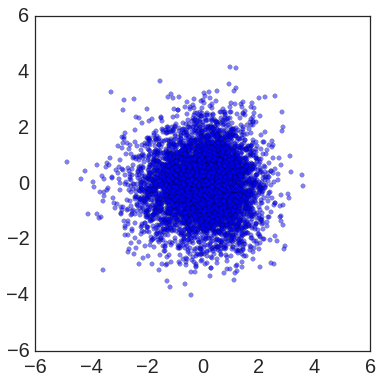

In [41]:
figsize(6,6)
plt.scatter(snpweights_on_map_codom.wPC1, snpweights_on_map_codom.wPC2, alpha = .5)
plt.show()

In [42]:
snpweights_paralogs = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.snpweights',
    sep = ' ', skipinitialspace = True, header = None)
snpweights_paralogs.columns = ['locus', 'LG', 'pos'] +  ['wPC{}'.format(x) for x in range(1,11)]

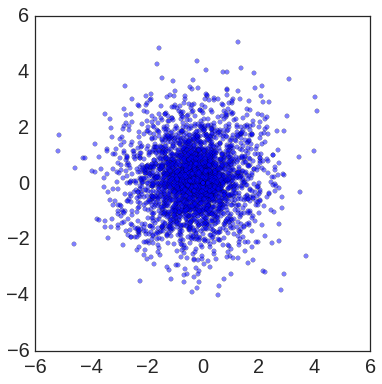

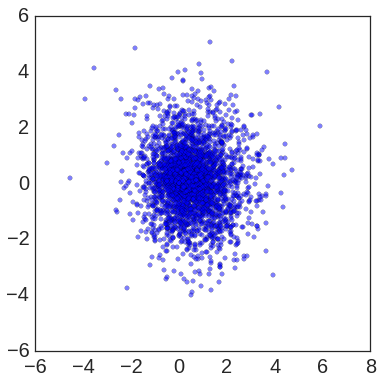

In [43]:
figsize(6,6)
plt.scatter(snpweights_paralogs.wPC1, snpweights_paralogs.wPC2, alpha = .5)
plt.show()
plt.scatter(snpweights_paralogs.wPC3, snpweights_paralogs.wPC2, alpha = .5)
plt.show()

#### Scree plot of eigenvalues

In [44]:
evals_on_map_codom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.eval',
    sep = ' ', skipinitialspace = True, header = None)
evals_on_map_dom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.eval',
    sep = ' ', skipinitialspace = True, header = None)
evals_paralogs_dom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.eval',
    sep = ' ', skipinitialspace = True, header = None)

evals_subsample_codom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.eval',
    sep = ' ', skipinitialspace = True, header = None)


evals_on_map_codom['percent_explained'] = 100*evals_on_map_codom[0]/np.sum(evals_on_map_codom[0])
evals_on_map_dom['percent_explained'] = 100*evals_on_map_dom[0]/np.sum(evals_on_map_dom[0])
evals_paralogs_dom['percent_explained'] = 100*evals_paralogs_dom[0]/np.sum(evals_paralogs_dom[0])
evals_subsample_codom['percent_explained'] = 100*evals_subsample_codom[0]/np.sum(evals_subsample_codom[0])


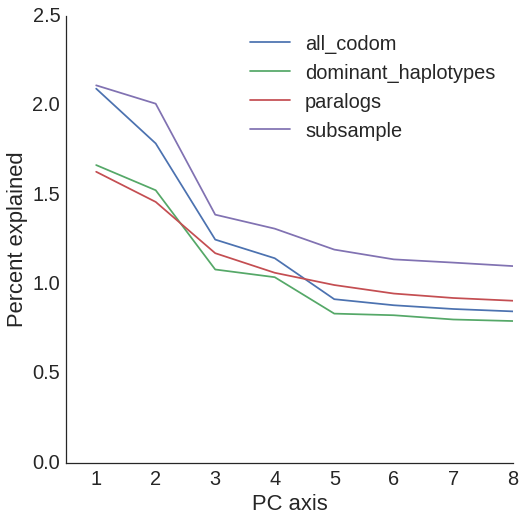

In [66]:
figsize(8,8)
plt.plot(evals_on_map_codom['percent_explained'], label = 'all_codom')
plt.plot(evals_on_map_dom['percent_explained'], label = 'dominant_haplotypes')
plt.plot(evals_paralogs_dom['percent_explained'], label = 'paralogs')
plt.plot(evals_subsample_codom['percent_explained'], label = 'subsample')
plt.xlim(-.5,7)
plt.xticks(range(0,8), range(1,9))
plt.legend()
plt.xlabel('PC axis')
plt.ylabel('Percent explained')
sns.despine()
plt.savefig('/home/ipseg/Desktop/waples/chum_populations/paper/figures/supplemental/PCA_eigenvalues.png')

#### Plot the first few PC axes for each of the data sets

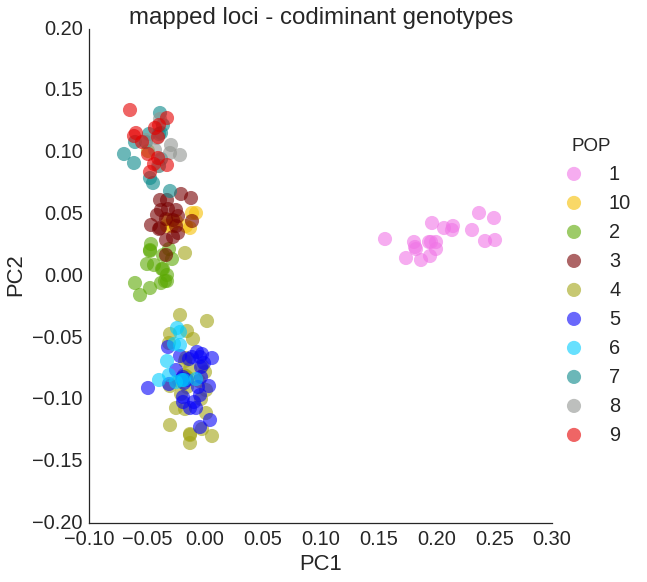

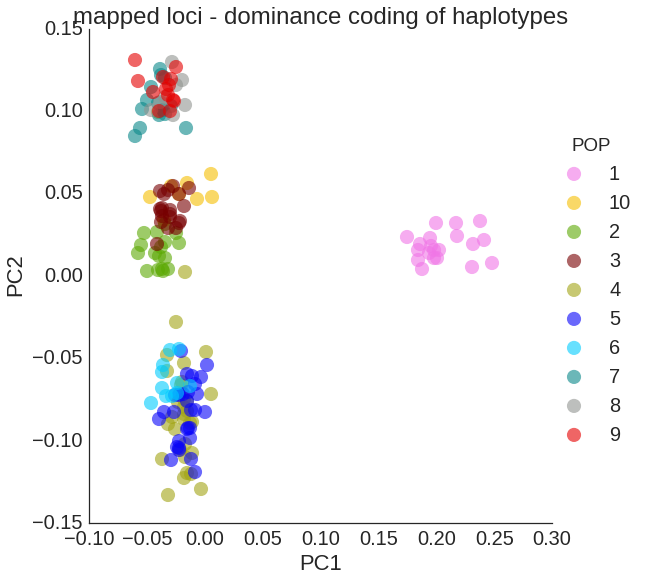

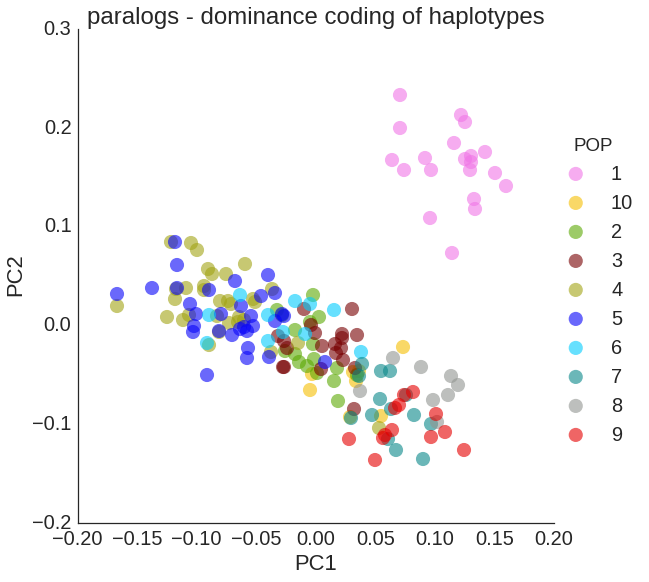

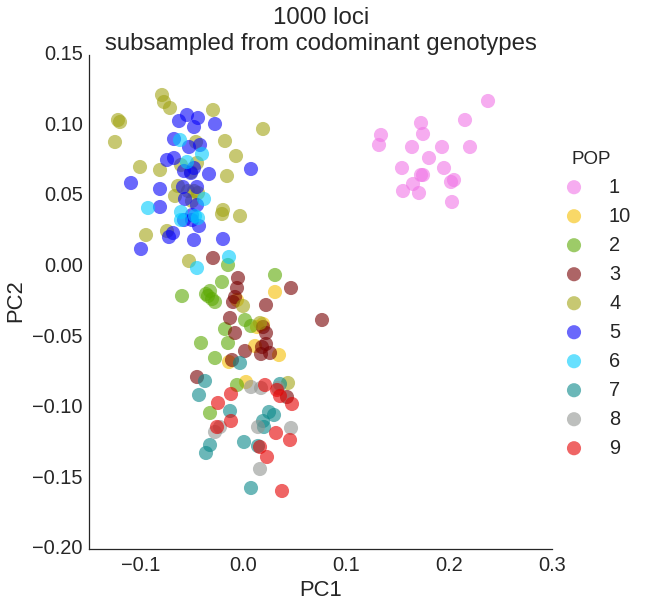

In [70]:
figsize(10, 10)

sns.lmplot('PC1', 'PC2', data= eigenvec_on_map_codom, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('mapped loci - codiminant genotypes')
sns.despine()
plt.savefig('/home/ipseg/Desktop/waples/chum_populations/paper/figures/PCA_codom.png')
plt.show()

sns.lmplot('PC1', 'PC2', data= eigenvec_on_map_dom, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('mapped loci - dominance coding of haplotypes')
sns.despine()
plt.savefig('/home/ipseg/Desktop/waples/chum_populations/paper/figures/PCA_dom.png')
plt.show()

sns.lmplot('PC1', 'PC2', data= eigenvec_paralogs, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('paralogs - dominance coding of haplotypes')
sns.despine()
plt.savefig('/home/ipseg/Desktop/waples/chum_populations/paper/figures/PCA_dom_paralogs.png')
plt.show()

sns.lmplot('PC1', 'PC2', data= eigenvec_on_map_codom_subsample, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('1000 loci \nsubsampled from codominant genotypes')
sns.despine()
plt.savefig('/home/ipseg/Desktop/waples/chum_populations/paper/figures/PCA_codom_subsample.png')
plt.show()


### Formally test for population structure
using the twstats program from EIGENSTRAT.

This program compares the distribution of output eigenvalues to those generated by the Tracy-Widom distribution, see Patterson (2006).

#### run twstats

In [47]:
! /home/ipseg/Programs/EIGENSOFT/EIG6.0.1/bin/twstats \
-t /home/ipseg/Programs/EIGENSOFT/EIG6.0.1/POPGEN/twtable \
-i /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.eval \
-o /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.tw

In [48]:
! /home/ipseg/Programs/EIGENSOFT/EIG6.0.1/bin/twstats \
-t /home/ipseg/Programs/EIGENSOFT/EIG6.0.1/POPGEN/twtable \
-i /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.eval \
-o /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.tw

In [49]:
!/home/ipseg/Programs/EIGENSOFT/EIG6.0.1/bin/twstats \
-t /home/ipseg/Programs/EIGENSOFT/EIG6.0.1/POPGEN/twtable \
-i /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.eval \
-o /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.tw

In [71]:
!/home/ipseg/Programs/EIGENSOFT/EIG6.0.1/bin/twstats \
-t /home/ipseg/Programs/EIGENSOFT/EIG6.0.1/POPGEN/twtable \
-i /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.eval \
-o /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.tw

#### Plot Tracy-Widom stats

In [72]:
tw_onmap_codom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.tw',
           sep = ' ', skipinitialspace = True)
tw_onmap_dom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.tw',
           sep = ' ', skipinitialspace = True)
tw_paralogs_dom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.tw',
           sep = ' ', skipinitialspace = True)
tw_subsample_codom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.subsample.tw',
           sep = ' ', skipinitialspace = True)

tw_paralogs_dom.head()

,#N,eigenvalue,difference,twstat,p-value,effect.,n
0,1,2.819728,NaN,58.892,7.155550e-133,1402.534,NaN
1,2,2.527649,-0.292079,51.406,1.022560e-108,1604.912,NaN
2,3,2.030819,-0.496830,24.982,4.447890e-38,1791.222,NaN
3,4,1.841122,-0.189697,14.272,1.776790e-17,1879.609,NaN
4,5,1.722421,-0.118701,7.334,5.373120e-08,1937.363,NaN


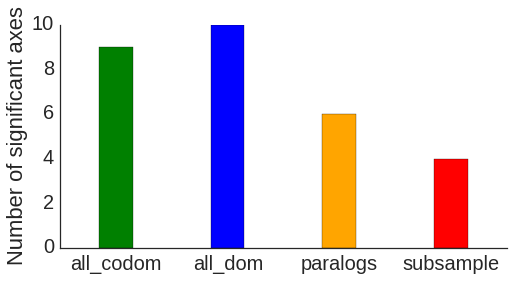

In [78]:
figsize(8,4)
#plt.plot(-np.log10(tw_onmap_codom['p-value']), label = 'all_codom')
#plt.plot(-np.log10(tw_onmap_dom['p-value']), label = 'all_dom')
#plt.plot(-np.log10(tw_paralogs_dom['p-value']), label = 'paralogs')
#plt.xlim(-1,10)
plt.bar(1, np.sum(tw_onmap_codom['p-value'] < .01), label = 'all_codom', color = 'green', align='center', width=0.3)
plt.bar(2, np.sum(tw_onmap_dom['p-value'] < .01), label = 'all_dom', color = 'blue', align='center', width=0.3)
plt.bar(3, np.sum(tw_paralogs_dom['p-value'] < .01), label = 'paralogs', color = 'orange', align='center', width=0.3)
plt.bar(4, np.sum(tw_subsample_codom['p-value'] < .01), label = 'subsample', color = 'red', align='center', width=0.3)
#plt.legend()
plt.ylabel('Number of significant axes')
plt.xticks([1,2,3, 4],['all_codom', 'all_dom', 'paralogs', 'subsample'])
sns.despine()
plt.savefig('/home/ipseg/Desktop/waples/chum_populations/paper/figures/supplemental/TW_stats.png')
plt.show()

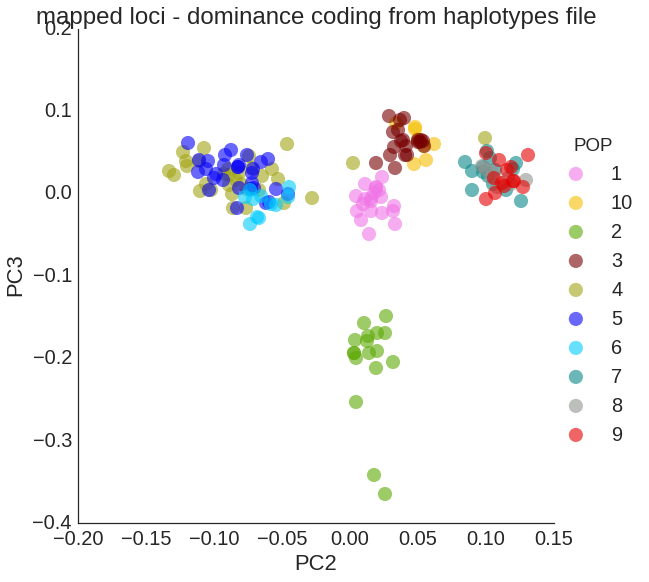

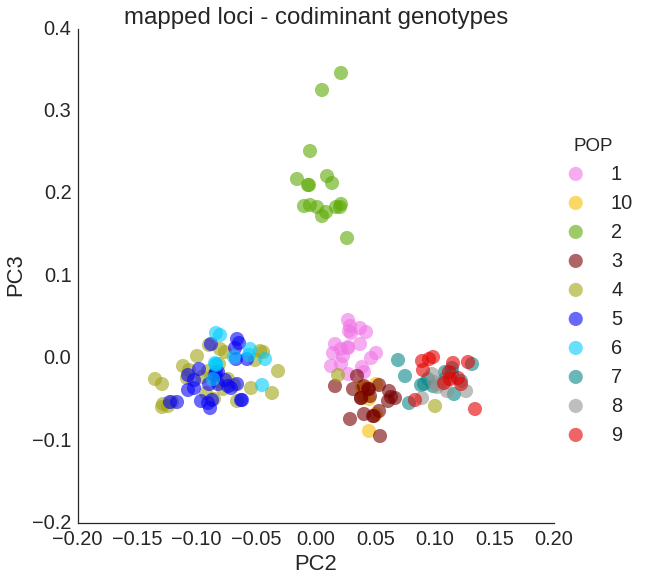

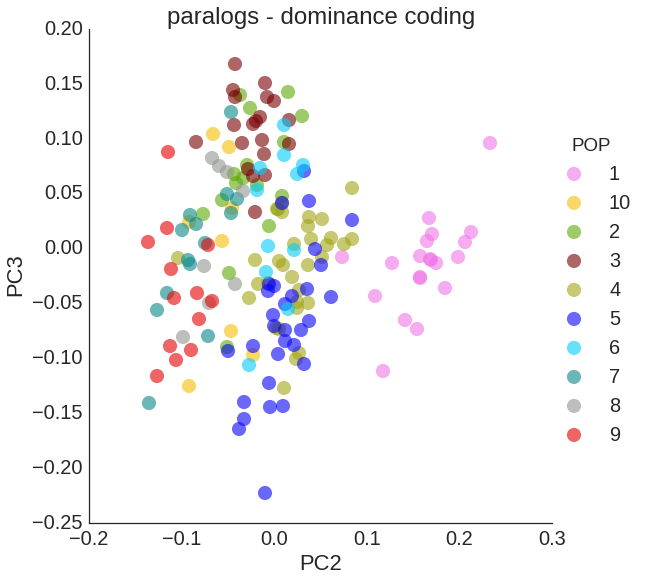

In [52]:
figsize(10, 10)
sns.lmplot('PC2', 'PC3', data= eigenvec_on_map_dom, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('mapped loci - dominance coding from haplotypes file')
plt.show()

sns.lmplot('PC2', 'PC3', data= eigenvec_on_map_codom, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('mapped loci - codiminant genotypes')
plt.show()

sns.lmplot('PC2', 'PC3', data= eigenvec_paralogs, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('paralogs - dominance coding')
plt.show()

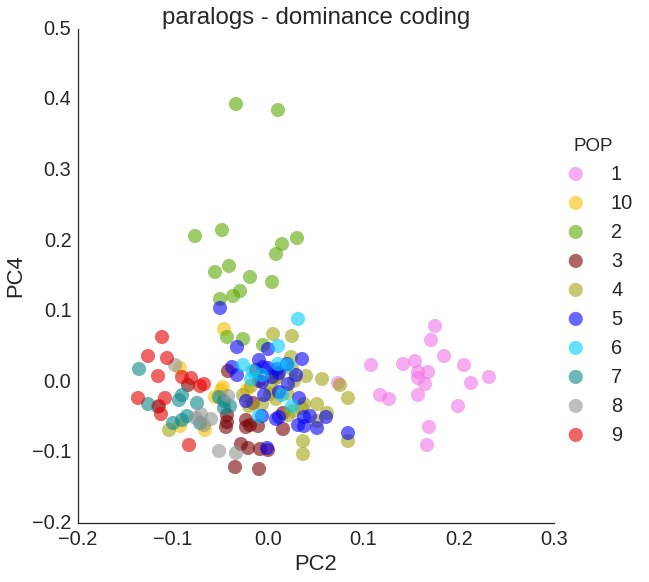

In [53]:
sns.lmplot('PC2', 'PC4', data= eigenvec_paralogs, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('paralogs - dominance coding')
plt.show()

### TODO 
   * look at evalues - include on plots
   * down sample to same number of loci
   * population names

## Examine the inferred relationship matrix

In [54]:
paralogs_rel = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.rel', header = None, sep = ' ')
paralogs_rel.columns = ['ind1', 'ind2', 'numloci', 'cov']
paralogs_rel.head()

,ind1,ind2,numloci,cov
0,1,1,4384,0.996642
1,2,1,4384,0.075349
2,2,2,4384,0.971388
3,3,1,4384,0.105840
4,3,2,4384,0.110046


In [55]:
import scipy.spatial.distance

In [56]:
def plot_rel_matrix(rel_file):
    rel = pd.read_csv(rel_file, header = None, sep = ' ')
    rel.columns = ['ind1', 'ind2', 'numloci', 'cov']
    rel_mat = np.zeros(shape = (max(rel['ind1']), max(rel['ind1'])))
    for idx, row in rel.iterrows():
        rel_mat[rel['ind1']-1, rel['ind2']-1] = rel['cov']
        rel_mat[rel['ind2']-1, rel['ind1']-1] = rel['cov']
    np.fill_diagonal(rel_mat, 0)
    #rel_sq = scipy.spatial.distance.squareform(rel['cov'])
    sns.heatmap(rel_mat, linewidth = 0, square = True, xticklabels = False, yticklabels = False, robust = True)
    plt.show()

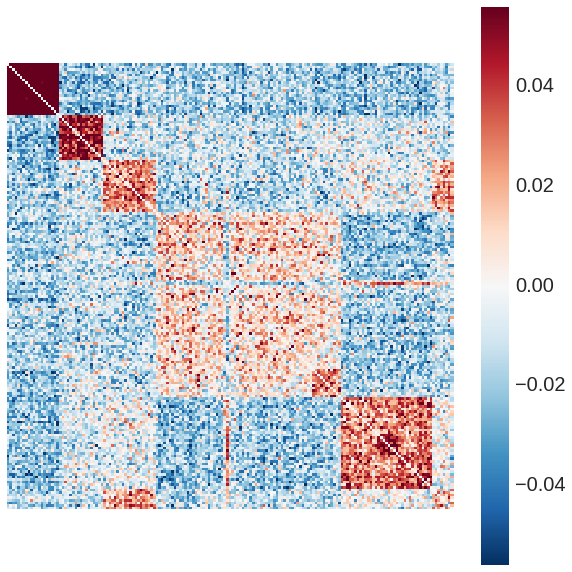

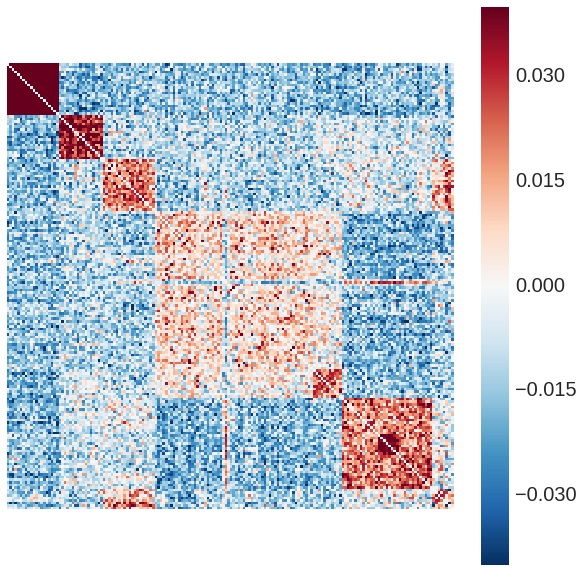

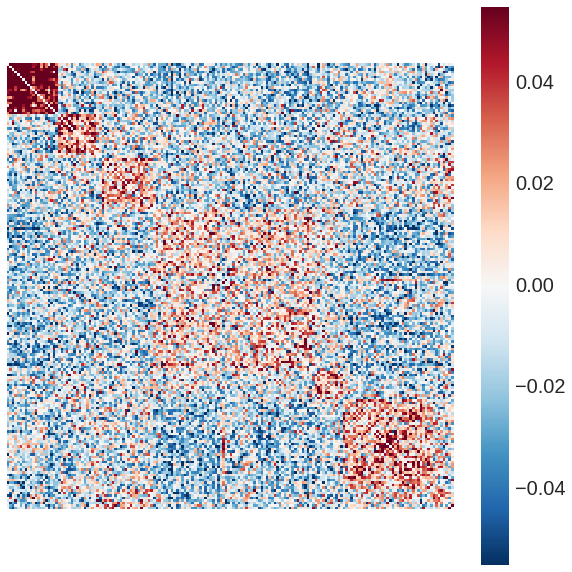

In [57]:
plot_rel_matrix('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.rel')
plot_rel_matrix('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.rel')
plot_rel_matrix('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.rel')